#### Import Necessary Packages

In [ ]:
import os
import shutil
import zipfile

import random
import math
from tqdm import tqdm

import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Flatten, Dense,\
                                    Dropout, BatchNormalization, Input
from tensorflow.keras.metrics import Mean, CosineSimilarity
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input

#### Establish paths

In [ ]:
#Connect to Drive Folder
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/My Drive/CapstoneProject'

/content/drive/My Drive/CapstoneProject


In [ ]:
FACE_DATA_PATH =       '/content/drive/My Drive/CapstoneProject/data/lfw_190MB/lfw_190MB/Face Data/Face Dataset'
EXTRACTED_FACES_PATH = '/content/drive/My Drive/CapstoneProject/data/lfw_190MB/lfw_190MB/Extracted Faces/Extracted Faces'

###Exploring the dataset

The dataset used is an iteration of the famous Labeled Faces in the Wild (LFW) dataset, commonly used for facial recognition.

The data is split into two parts:
- The face data, which are the collected images of different people's faces
- The extracted faces, which are formatted images taken from the face data that align the biometric feature (eyes, nose mouth, ect) for the faces for easier reading.

In [ ]:
def explore_folder(folder_path):
    print(f'Exploring {os.path.basename(folder_path)}')
    image_shapes = []
    num_images = 0
    num_people = 0
    for folder_name in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, folder_name)
        for image_name in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_name)
            image = cv2.imread(image_path)
            image_shapes.append(image.shape)
            num_images += 1
        num_people +=1
    print(f'Unique image shapes in: {set(image_shapes)}')
    print(f"Total number of images: {num_images}")
    print(f"Total number of people: {num_people}")
    return image_shapes, num_images, num_people

In [ ]:
explore_folder(FACE_DATA_PATH)

Exploring Face Dataset
Unique image shapes in: {(250, 250, 3)}
Total number of images: 8204
Total number of people: 1680


([(250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3),
  (250, 250, 3

In [ ]:
explore_folder(EXTRACTED_FACES_PATH);

Exploring Extracted Faces
Unique image shapes in: {(128, 128, 3)}
Total number of images: 6107
Total number of people: 1324


## Visualize Dataset

This displays a sampling of the image from the dataset to demonstrate the appearance, comprehensiveness and visual diversity of the dataset

In [ ]:
def visualize_sample_images(folder_path):
    num_images = len(os.listdir(folder_path))
    num_rows = (num_images + 4) // 5
    num_cols = min(num_images, 5)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 3 * num_rows))

    for i, image_name in enumerate(os.listdir(folder_path)):
        image_path = os.path.join(folder_path, image_name)
        sample_image = cv2.imread(image_path)
        sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

        row = i // num_cols
        col = i % num_cols

        if num_rows == 1:
              ax = axes[col]
        else:
            ax = axes[row, col]

        ax.imshow(sample_image)
        ax.axis('off')

    for ax in axes.flat[num_images:]:
          ax.remove()

    plt.suptitle(f'Person ID: {os.path.basename(folder_path)}')
    plt.tight_layout()
    plt.show()

Samples from Face Dataset


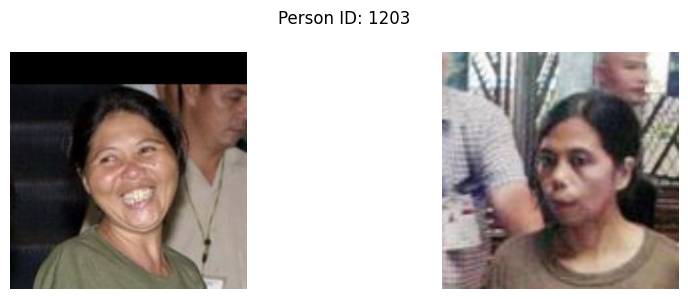

In [ ]:
person_id = random.choice(os.listdir(FACE_DATA_PATH))
folder_path = os.path.join(FACE_DATA_PATH, person_id)
print(f'Samples from {os.path.basename(FACE_DATA_PATH)}')
visualize_sample_images(folder_path)

Samples from Extracted Faces


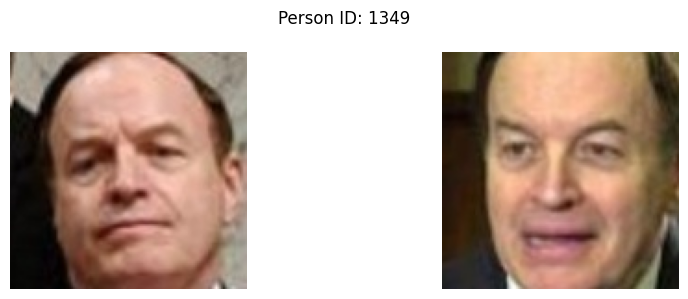

In [ ]:
person_id = random.choice(os.listdir(EXTRACTED_FACES_PATH))
folder_path = os.path.join(EXTRACTED_FACES_PATH, person_id)
print(f'Samples from {os.path.basename(EXTRACTED_FACES_PATH)}')
visualize_sample_images(folder_path)

Samples from Extracted Faces


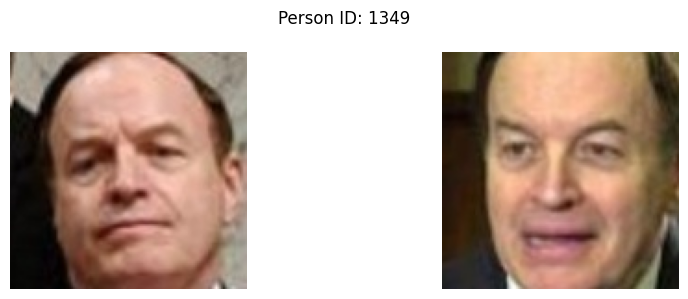

In [ ]:
print(f'Samples from {os.path.basename(EXTRACTED_FACES_PATH)}')
if person_id in os.listdir(EXTRACTED_FACES_PATH):
    folder_path = os.path.join(EXTRACTED_FACES_PATH, person_id)
    visualize_sample_images(folder_path)
else:
    print(f'There is no person {person_id} in this folder')


#### Create the Dataset

This consolidates the face data and the extracted faces into a unified dataset. This increases the size of the data. The data we can feed it, the better out model will perform.

In [ ]:
DATASET = 'images/output_dataset'
if os.path.exists(DATASET):
    shutil.rmtree(DATASET)
os.makedirs(DATASET)

def copy_to_output_dataset(input_path, output_path):
    for person_folder in os.listdir(input_path):
        person_folder_path = os.path.join(input_path, person_folder)
        if os.path.isdir(person_folder_path):
            output_person_folder = os.path.join(output_path, person_folder)
            if not os.path.exists(output_person_folder):
                os.makedirs(output_person_folder)

            for image_file in os.listdir(person_folder_path):
                if image_file.endswith('.jpg'):
                    src_image_path = os.path.join(person_folder_path, image_file)
                    dst_image_path = os.path.join(output_person_folder, image_file)
                    if os.path.exists(dst_image_path):
                        base, ext = os.path.splitext(dst_image_path)
                        dst_image_path = f"{base}_1{ext}"
                    shutil.copy(src_image_path, dst_image_path)

copy_to_output_dataset(FACE_DATA_PATH, DATASET)
copy_to_output_dataset(EXTRACTED_FACES_PATH, DATASET)

In [ ]:
explore_folder(DATASET);

Exploring output_dataset
Unique image shapes in: {(250, 250, 3), (128, 128, 3)}
Total number of images: 14311
Total number of people: 1680


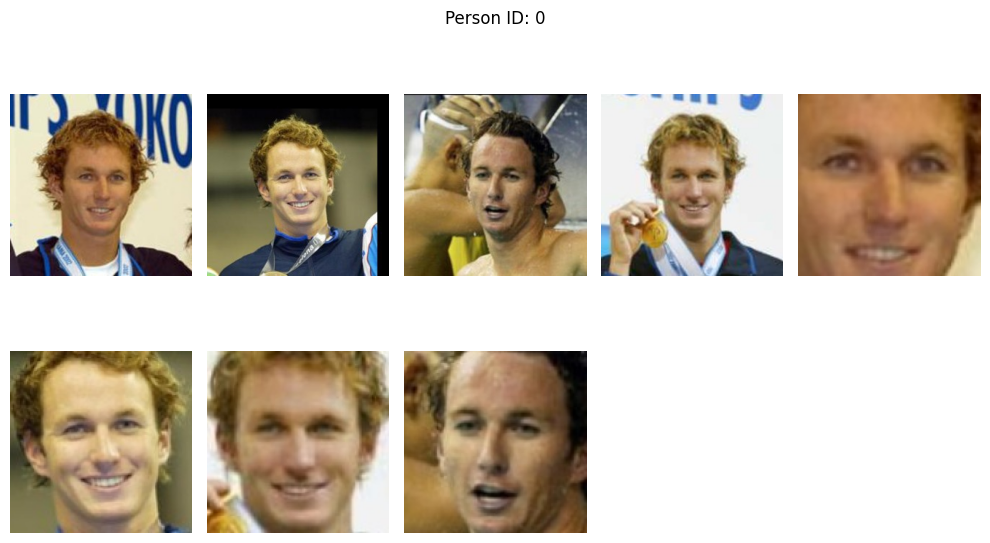

In [ ]:
visualize_sample_images(os.path.join(DATASET, '0'))

## Create Triplets

We must now separate out consolidated dataset into triplets. Triplets are sets of three images that we can separate our images out into, to help the model distinguish between matching faces and non-matching faces.

The three classes of image in a triplet are:

- **Anchor Images:** An image of a particular person's face
- **Positive Images:** An image that is a match to the person in the anchor image
- **Negative Images:** An image that is *not* the person in the anchor nor positive image

These are used to calculate the *triplet loss*.


##### **Triplet Loss:**

 ## $\sum \limits _{i} ^{N}[||f(x_i^{a})-f(x_i^{a})||_2^{2}-||f(x_i^{a}) - f(x_i^{n})||_2^{2} +\alpha]$

In [ ]:
def triplets(folder_paths, max_triplets=7):
    anchor_images = []
    positive_images = []
    negative_images = []

    for person_folder in folder_paths:
        images = [os.path.join(person_folder, img)
                  for img in os.listdir(person_folder)]
        num_images = len(images)

        if num_images < 2:
            continue

        random.shuffle(images)

        for _ in range(max(num_images-1, max_triplets)):
            anchor_image = random.choice(images)

            positive_image = random.choice([x for x in images
                                            if x != anchor_image])

            negative_folder = random.choice([x for x in folder_paths
                                             if x != person_folder])

            negative_image = random.choice([os.path.join(negative_folder, img)
                                            for img in os.listdir(negative_folder)])

            anchor_images.append(anchor_image)
            positive_images.append(positive_image)
            negative_images.append(negative_image)

    return anchor_images, positive_images, negative_images

In [ ]:
person_folders = [os.path.join(DATASET, folder_name)
                  for folder_name in os.listdir(DATASET)]

anchors, positives, negatives = triplets(person_folders)

#### Splitting the triplet dataset

Triplets are needed to train a Siamese Network, which contain a training set and a validation set, both of which are made up of triplets.

The training set optimizes model parameters, while the validation set monitor's model performance and prevents overfitting.

In [ ]:
def split_triplets(anchors,
                   positives,
                   negatives,
                   validation_split=0.2):

    triplets = list(zip(anchors, positives, negatives))

    train_triplets, val_triplets = train_test_split(triplets,
                                                    test_size=validation_split,
                                                    random_state=42)

    return train_triplets, val_triplets

In [ ]:
train_triplets, val_triplets = split_triplets(anchors,
                                              positives,
                                              negatives)
len(train_triplets), len(val_triplets)

(13854, 3464)

## Image Preprocessing

The image must be pre-processed before they are run throught the model, standardizing the images' size, coloring, space conversion and dimensions

In [ ]:
def load_and_preprocess_image(image_path, expand_dims=False):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))
    if expand_dims:
        image = np.expand_dims(image, axis=0)
    return image

## Generate Batches

Even though we have over 1600 faces to work with, we still need to increase the diversity of our dataset by applying some transformations to the input, through *data augemntation.*

The batch generation function below not only breaks the dataset up into batchs for when it is fed to the model, but it also performs some data augmentation to the images.

These augmentations include:

- Random rotation
- Random horizontal and vertical shifting
- Horizontal flipping
- Random zooming

In [ ]:
def batch_generator(triplets, batch_size=32, augment=True):
    total_triplets = len(triplets)
    random_indices = list(range(total_triplets))
    random.shuffle(random_indices)

    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=True,
        zoom_range=0.2
    )

    for i in range(0, total_triplets, batch_size):
        batch_indices = random_indices[i:i + batch_size]
        batch_triplets = [triplets[j] for j in batch_indices]

        anchor_batch = []
        positive_batch = []
        negative_batch = []

        for triplet in batch_triplets:
            anchor, positive, negative = triplet

            anchor_image = load_and_preprocess_image(anchor)
            positive_image = load_and_preprocess_image(positive)
            negative_image = load_and_preprocess_image(negative)

            if augment:
                anchor_image = datagen.random_transform(anchor_image)
                positive_image = datagen.random_transform(positive_image)
                negative_image = datagen.random_transform(negative_image)

            anchor_batch.append(anchor_image)
            positive_batch.append(positive_image)
            negative_batch.append(negative_image)

        yield [np.array(anchor_batch),
               np.array(positive_batch),
               np.array(negative_batch)]

#### Visualize random batch of triplets

In [ ]:
def visualize_triplets(triplets):
    anchor_batch, positive_batch, negative_batch = triplets

    for i in range(len(anchor_batch)):
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.title("Anchor")
        plt.imshow(anchor_batch[i])
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Positive")
        plt.imshow(positive_batch[i])
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Negative")
        plt.imshow(negative_batch[i])
        plt.axis('off')

        plt.show()

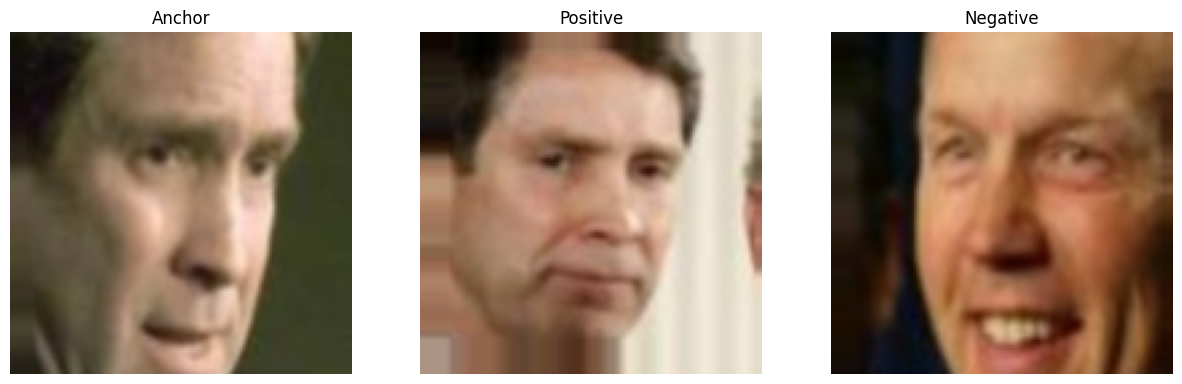

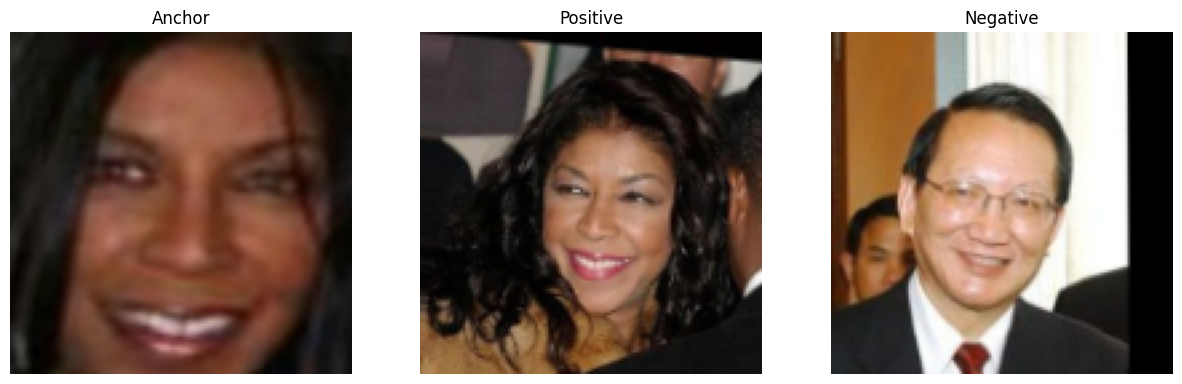

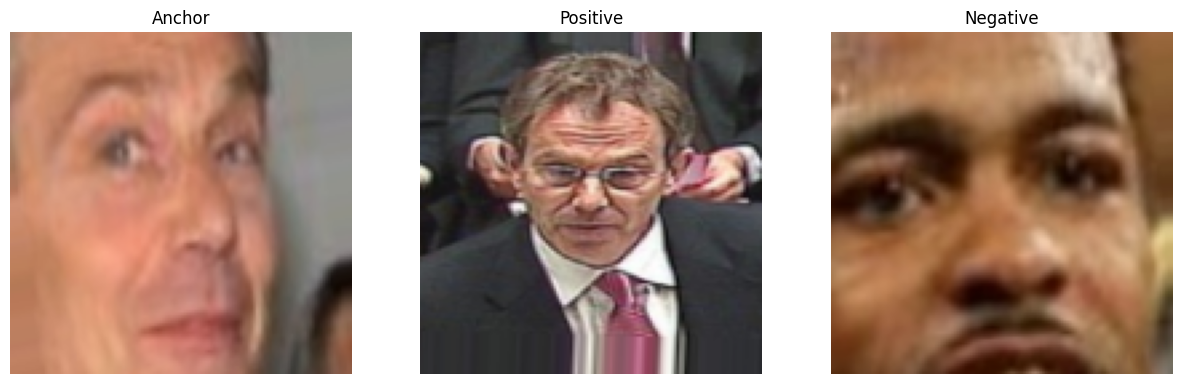

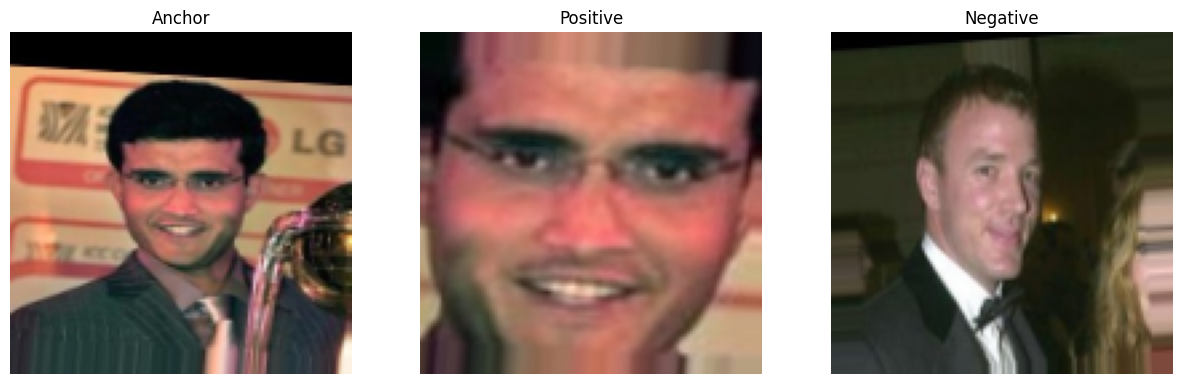

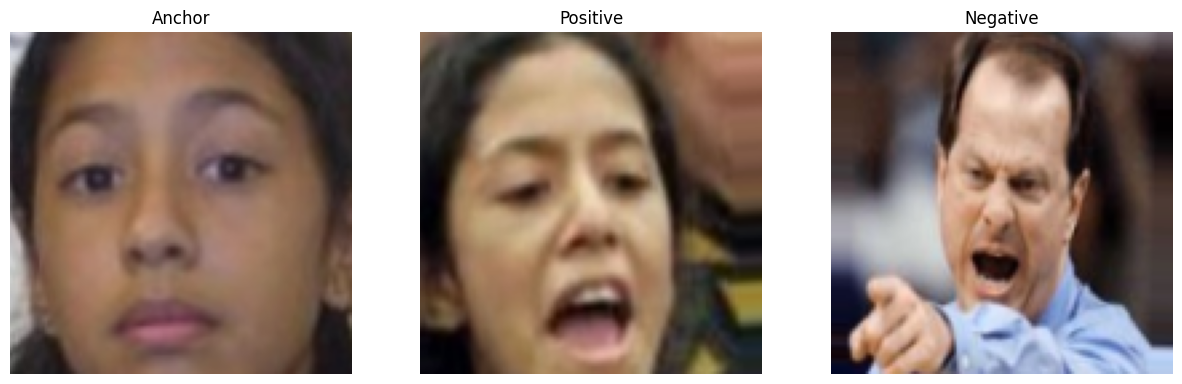

In [ ]:
example_triplets = [next(batch_generator(train_triplets, 5))]
visualize_triplets(example_triplets[0])

## Acquire Facial Embeddings

Embeddings are meaningful represntations of the input images. For this model, we are extracting facial embbedings which closely correlate with the biometric layout of a person's face.

To derive these embdeddings to utilizing an embedding model to transform images into a feature space, clustering similar and different faces.

For the embedding model we will utilize the **EfficientNetB7** architecture as a base model. EfficientNetB7 is a pre-trained network that has been trained on the famous and comprehensive ImageNet dataset. This essentially creates additional model layers on top of the Siamese Network.

In [ ]:
def get_embedding(input_shape, num_layers_to_unfreeze=25):
    base_model = EfficientNetB7(weights='imagenet',
                                input_shape=input_shape,
                                include_top=False,
                                pooling='avg')

    for i in range(len(base_model.layers)-num_layers_to_unfreeze):
        base_model.layers[i].trainable = False

    embedding = tf.keras.models.Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(128)
    ], name='Embedding')

    return embedding

In [ ]:
input_shape = (128, 128, 3)

embedding = get_embedding(input_shape)
embedding.summary()

258076736/258076736 [==============================] - 2s 0us/step
Model: "Embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 2560)              64097687  
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 512)               1311232   
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

## Siamese Network Architecture

Now we begin to define the architecture of the actual Siamese Network. This model will operate off of the basic premise of minimizing the distance between anchor and positive embeddings and maximize the distance betwwn the anchor and negative embeddings.

This distances are the *Euclidean distance* and ar used to calculate triplet loss during training.


#### Distance Layer

In [ ]:
@tf.keras.saving.register_keras_serializable()
class DistanceLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return ap_distance, an_distance

anchor_input = Input(name='anchor', shape=input_shape)
positive_input = Input(name='positive', shape=input_shape)
negative_input = Input(name='negative', shape=input_shape)

distances = DistanceLayer()(
    embedding(preprocess_input(anchor_input)),
    embedding(preprocess_input(positive_input)),
    embedding(preprocess_input(negative_input))
)

siamese_net = Model(
    inputs=[anchor_input,
            positive_input,
            negative_input],
    outputs=distances
)

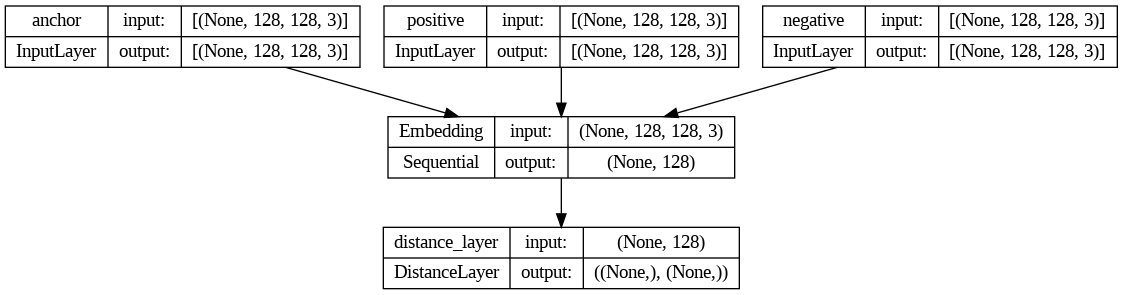

In [ ]:
plot_model(siamese_net, show_shapes=True, show_layer_names=True)

In [ ]:
siamese_net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 anchor (InputLayer)         [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 positive (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 negative (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Embedding (Sequential)      (None, 128)                  6559323   ['anchor[0][0]',              
                                                          9          'positive[0][0]',        

## Model Creation

In [ ]:
@tf.keras.saving.register_keras_serializable()
class SiameseModel(Model):
    def __init__(self, siamese_net, margin=0.5):
        super().__init__()
        self.siamese_net = siamese_net
        self.margin = margin
        self.loss_tracker = Mean(name='loss')
        self.accuracy_tracker = Mean(name='accuracy')

    def call(self, inputs):
        return self.siamese_net(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_net.trainable_weights)

        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_net.trainable_weights)
        )

        self.loss_tracker.update_state(loss)

        accuracy = self._compute_accuracy(data)
        self.accuracy_tracker.update_state(accuracy)

        return {'loss': self.loss_tracker.result(),
                'accuracy': self.accuracy_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)

        accuracy = self._compute_accuracy(data)
        self.accuracy_tracker.update_state(accuracy)

        return {'loss': self.loss_tracker.result(),
                'accuracy': self.accuracy_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_net(data)

        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, .0)
        return loss

    def _compute_accuracy(self, data):
        ap_distance, an_distance = self.siamese_net(data)
        accuracy = tf.reduce_mean(tf.cast(ap_distance < an_distance,
                                          tf.float32))
        return accuracy

    @property
    def metrics(self):
        return [self.loss_tracker, self.accuracy_tracker]

    def get_config(self):
        base_config = super().get_config()
        config = {
            'siamese_net': tf.keras.saving.serialize_keras_object(self.siamese_net),
            'margin': tf.keras.saving.serialize_keras_object(self.margin),
            'loss_tracker': tf.keras.saving.serialize_keras_object(self.loss_tracker),
            'accuracy_tracker': tf.keras.saving.serialize_keras_object(self.accuracy_tracker),
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        config['siamese_net'] = tf.keras.saving.deserialize_keras_object(config.pop('siamese_net'))
        config['margin'] = tf.keras.saving.deserialize_keras_object(config.pop('margin'))
        config['loss_tracker'] = tf.keras.saving.deserialize_keras_object(config.pop('loss_tracker'))
        config['accuracy_tracker'] = tf.keras.saving.deserialize_keras_object(config.pop('accuracy_tracker'))
        return cls(**config)

## Model Training

In [ ]:
def train_model(model,
                train_triplets,
                epochs,
                batch_size,
                val_triplets,
                patience,
                delta=0.0001):

    best_val_accuracy = 0
    best_val_loss = float('inf')
    temp_patience = patience
    history = {
        'loss': [],
        'val_loss': [],
        'accuracy': [],
        'val_accuracy': []
    }

    train_steps_per_epoch = math.ceil(len(train_triplets) / batch_size)
    val_steps_per_epoch = math.ceil(len(val_triplets) / batch_size)

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        train_loss = 0.
        train_accuracy = 0.
        val_loss = 0.
        val_accuracy = 0.

        with tqdm(total=train_steps_per_epoch, desc='Training') as pbar:
            for batch in batch_generator(train_triplets, batch_size=batch_size):
                loss, accuracy = model.train_on_batch(batch)
                train_loss += loss
                train_accuracy += accuracy

                pbar.update()
                pbar.set_postfix({'Loss': loss, 'Accuracy': accuracy})

        with tqdm(total=val_steps_per_epoch, desc='Validation') as pbar:
            for batch in batch_generator(val_triplets, batch_size=batch_size):
                loss, accuracy = model.test_on_batch(batch)
                val_loss += loss
                val_accuracy += accuracy

                pbar.update()
                pbar.set_postfix({'Loss': loss, 'Accuracy': accuracy})

        train_loss /= train_steps_per_epoch
        train_accuracy /= train_steps_per_epoch
        val_loss /= val_steps_per_epoch
        val_accuracy /= val_steps_per_epoch

        history['loss'].append(train_loss)
        history['accuracy'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f'\nTrain Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}\n')

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            model.layers[0].layers[3].save_weights('best_model.weights.h5')

        if val_loss - best_val_loss > delta:
            temp_patience -= 1
            if temp_patience == 0:
                print('Early stopping: Validation loss did not improve.')
                break
        else:
            best_val_loss = val_loss
            temp_patience = patience

    return model, history

In [ ]:
siamese_model = SiameseModel(siamese_net)
siamese_model.compile(optimizer=Adam(0.001))

siamese_model, history = train_model(siamese_model,
                                     train_triplets=train_triplets,
                                     epochs=1,
                                     batch_size=128,
                                     val_triplets=val_triplets,
                                     patience=3)

Epoch 1/1


Validation: 100%|██████████| 28/28 [1:01:50<00:00, 132.53s/it, Loss=0.304, Accuracy=0.75]



Train Loss: 0.2265, Train Accuracy: 0.8771
Validation Loss: 0.1881, Validation Accuracy: 0.8463



In [ ]:
"""# Define the get_config method for the SiameseModel class
def siamese_model_get_config(model):
    return {
        'siamese_net': tf.keras.saving.serialize_keras_object(model.siamese_net),
        'loss_tracker': tf.keras.saving.serialize_keras_object(model.loss_tracker),
        'accuracy_tracker': tf.keras.saving.serialize_keras_object(model.accuracy_tracker),
    }

# Set the get_config method for the SiameseModel class
SiameseModel.get_config = siamese_model_get_config

# Save the model specifying the input shape and signature
siamese_model.save('/content/drive/My Drive/CapstoneProject/siamese_model', save_format='tf', signatures={'serving_default': model_call})

# Convert the SavedModel to TensorFlow Lite format for mobile deployment
converter = tf.lite.TFLiteConverter.from_saved_model('/content/drive/My Drive/CapstoneProject/siamese_model')
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('/content/drive/My Drive/CapstoneProject/siamese_model.tflite', 'wb') as f:
    f.write(tflite_model)"""


## Evaluation

#### Cosine Similarity

In [ ]:
sample = next(batch_generator(val_triplets, 1))

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(preprocess_input(anchor)),
    embedding(preprocess_input(positive)),
    embedding(preprocess_input(negative))
)

cosine_similarity = CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print(f'Positive similarity: {positive_similarity}')

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print(f'Negative similarity: {negative_similarity}')

Positive similarity: 0.9892876148223877
Negative similarity: 0.9636955857276917
